# Uso de Suelo

> Clases y métodos para extraer y procesar información sobre el uso de suelo.

* **Soportes**: Clase para construir diferentes tipos de soporte espacial y procesar variables
* **UsoDeSuelo**: Clase para definir tipos de uso de suelo, variables del medio construido y generar diferentes índices.

In [ ]:
#| default_exp usodesuelo

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from abc import ABC, abstractmethod
from fastcore.basics import *
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio
from pyproj.crs import crs
from rasterio.features import shapes
from shapely.geometry import Polygon
from geocube.api.core import make_geocube
import numpy as np
from pyLandUseMX.descargas import *
from pyLandUseMX.denue import *
import warnings
import random
from typing import Union
from pathlib import Path

In [ ]:
%load_ext autoreload
%autoreload 2

## Soporte espacial

Para trabajar con datos sobre uso de suelo y estructura urbana, necesitamos definir el soporte espacial (entendido como una teselación del espacio de estudio) que va a ser base para estudiar el uso de suelo. Podemos pensar que existen dos tipos generales de soporte espacial: regulares e irregulares. Los soportes regulares cubren el espacio utilizando siempre la misma figura, como en el caso de las mallas rectangulares o hexagonales, por otro lado, los soportes irregulares cubren el espacio con polígonos arbitrarios, como en el caso de los municipios, AGEBs o colonias.

En este módulo incluimos clases y métodos que nos permiten trabajar con diferentes tipos de soporte espacial. Estos métodos pueden ser usados de forma directa, creando objetos de las clases `Malla` o `Poligonos` para agregar y calcular variables de uso de suelo y medio construido, o a través de la clase `UsoDeSuelo` que implementa algunas herramientas de análisis.


In [ ]:
#| export
class Soporte(ABC):
    """Clase abstracta que define la interfaz para los diferentes tipos de Soporte."""
    @abstractmethod
    def agrega_puntos(self,
                      puntos:gpd.GeoDataFrame,
                      campo:str,
                      clasificacion:str
        ):
        """ Debe proveer la funcionalidad para agregar puntos en los elementos de la Soporte."""
        pass

    @abstractmethod
    def agrega_lineas(self,
                      lineas:gpd.GeoDataFrame,
                      campo:str
        ):
        """ Debe proveer la funcionalidad para agregar líneas en los elementos de la Soporte."""
        pass
    
    @abstractmethod
    def agrega_manzanas(self,
                        manzanas:gpd.GeoDataFrame,
                        variables: str                        
        ):
        """ Debe agregar variables del censo en la Soporte. """
        pass

    @abstractmethod
    def to_crs(self,
               to_crs:Union[int, str, crs.CRS]
    ):
        """ Se encarga de transformar de coordenadas."""
        pass

### Mallas
Algunos tipos de análisis, como las regresiones de uso de suelo para contaminantes atomsféricos, utilizan datos de uso de suelo en mallas. Para este tipo de aplicaciones la librería provee un conjunto de herramientas para crear mallas y agregar datos en ellas.

El primer elemento de este módulo es una Clase para contener la funcionalidad que vamos a implementar. Vamos a comenzar por definir la estructura básica de la clase y luego iremos agregando funcionalidad.

In [ ]:
#| export

class Malla(Soporte):
    """ Representa una malla para procesar variables de uso de suelo."""
    def __init__ (self,
                  datos:gpd.GeoDataFrame=None, # La malla vectorial
                  size:float=1000, # Tamaño de los elementos de la malla (en las unidades de la proyección de `layer`)
        ) -> None:
        self.size = size
        self.datos = datos
        self.crs = datos.crs
    
    @classmethod
    def desde_capa(cls, 
                  capa:gpd.GeoDataFrame, # La capa que define la extensión de la malla 
                  size:float # Tamaño de la malla en unidades de la proyección
        ):
        xmin, ymin, xmax, ymax = capa.total_bounds
        cols = list(np.arange(xmin, xmax + size, size))
        rows = list(np.arange(ymin, ymax + size, size))

        polygons = []
        for x in cols[:-1]:
            for y in rows[:-1]:
                polygons.append(Polygon([(x,y), (x + size, y), (x + size, y + size), (x, y + size)]))

        grid = (gpd
            .GeoDataFrame({'geometry':polygons})
            .set_crs(capa.crs)
            .reset_index()
            .rename({'index':'grid_id'}, axis=1))
        malla = cls(grid, size)
        return malla
    
    @classmethod
    def desde_raster(cls,
                    raster: Union[str, Path] # El raster a partir del que vamos a crear la malla.
        ):
        mask = None
        with rasterio.Env():
            with rasterio.open(raster) as src:
                image = src.read(1).astype('float32') # Habría que probar esto con raster diferentes
                results = (
                    {'properties': {'grid_id': i}, 'geometry': s}
                    for i, (s, v) 
                    in enumerate(
                        shapes(image, mask=mask, transform=src.transform))
                )
        geoms = list(results)
        gdf = gpd.GeoDataFrame.from_features(geoms).set_crs(src.crs.to_string())
        print(gdf.crs)
        return cls(gdf, src.res[0])

    def to_crs(self, to_crs: Union[int, str, crs.CRS]):
        ...

    def agrega_lineas(self, lineas: gpd.GeoDataFrame, campo: str=None):
        ...
    
    def agrega_puntos(self, puntos: gpd.GeoDataFrame, campo: str=None, clasificacion: str=None):
        ...
    def agrega_manzanas(self, manzanas: gpd.GeoDataFrame, variables):
        ...

La clase `Malla` contiene dos campos: `size` y `datos` con el tamaño de los elementos de la retícula y el `GeoDataFrame` con los polígonos de la malla respectivamente. Por lo pronto la clase sólo tiene un _classmethod_ que nos permite construir un objeto a partir de una capa vectorial: 

In [ ]:
show_doc(Malla.desde_capa)

---

[source](https://github.com/CentroGeo/pyLandUseMX/blob/master/pyLandUseMX/usodesuelo.py#L72){target="_blank" style="float:right; font-size:smaller"}

### Malla.desde_capa

>      Malla.desde_capa (capa:geopandas.geodataframe.GeoDataFrame, size:float)

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| capa | GeoDataFrame | La capa que define la extensión de la malla |
| size | float | Tamaño de la malla en unidades de la proyección |

El archivo ya está descargado


<AxesSubplot:>

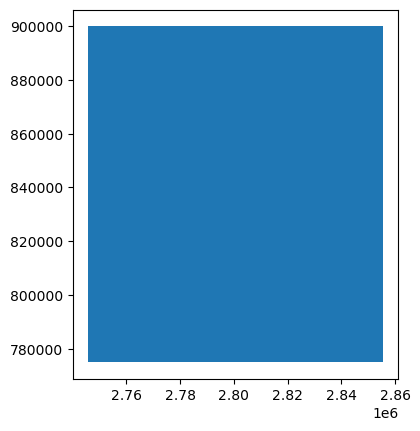

In [ ]:
pth = descarga_poligonos_ciudades()
zmvm = gpd.read_file(pth)
zmvm = zmvm.loc[zmvm.CVE_SUN == '13']
malla = Malla.desde_capa(zmvm, 1000)
malla.datos.plot()

Podemos ver la malla superpuesta al polígono que usamos para construirla:

<AxesSubplot:>

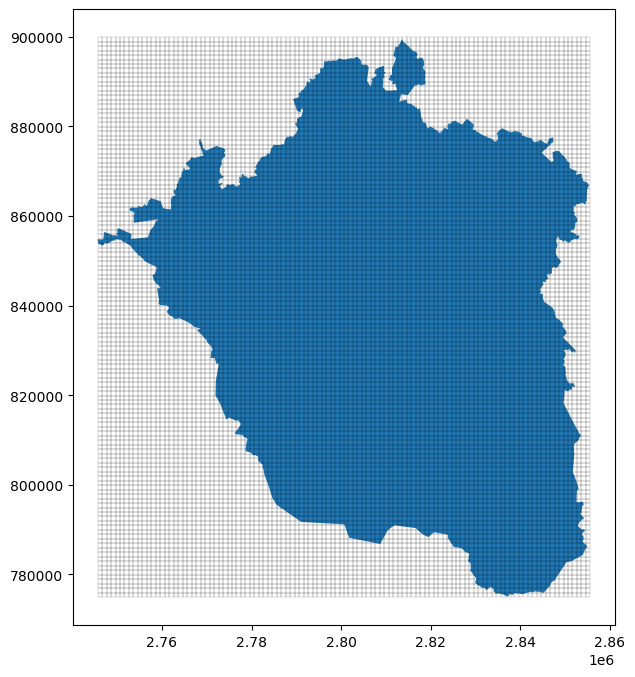

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
zmvm.plot(ax=ax)
malla.datos.boundary.plot(ax=ax, edgecolor="black", linewidth=0.1)

#### Malla.desde_raster

También podemos crear una malla a partir de un raster (p. ej. un geotiff), en este se crea una malla con las mismas características que el raster de entrada.

In [ ]:
show_doc(Malla.desde_raster)

---

[source](https://github.com/CentroGeo/pyLandUseMX/blob/master/pyLandUseMX/usodesuelo.py#L94){target="_blank" style="float:right; font-size:smaller"}

### Malla.desde_raster

>      Malla.desde_raster (raster:Union[str,pathlib.Path])

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| raster | typing.Union[str, pathlib.Path] | El raster a partir del que vamos a crear la malla. |

In [ ]:
pth_raster = descarga_raster_ejemplo()
malla_raster = Malla.desde_raster(pth_raster)
malla_raster.datos

El archivo ya está descargado
EPSG:4326


,geometry,grid_id
0,"POLYGON ((-99.65011 20.06836, -99.65011 20.059...",0
1,"POLYGON ((-99.64113 20.06836, -99.64113 20.059...",1
2,"POLYGON ((-99.63215 20.06836, -99.63215 20.059...",2
3,"POLYGON ((-99.62317 20.06836, -99.62317 20.059...",3
4,"POLYGON ((-99.61418 20.06836, -99.61418 20.059...",4
...,...,...
14963,"POLYGON ((-98.63502 18.93649, -98.63502 18.927...",14963
14964,"POLYGON ((-98.62604 18.93649, -98.62604 18.927...",14964
14965,"POLYGON ((-98.61705 18.93649, -98.61705 18.927...",14965
14966,"POLYGON ((-98.60807 18.93649, -98.60807 18.927...",14966


#### Transformación de coordenadas

In [ ]:
#| export
@patch
def to_crs(self:Malla,
           to_crs: Union[int, str, crs.CRS] # El crs al que queremos reproyectar
    ) -> Malla:
    datos = self.datos.to_crs(to_crs)
    m = Malla(datos, self.size)
    return m

In [ ]:
malla_raster_utm = malla_raster.to_crs(32614)
print(malla_raster_utm.crs.to_string(), malla_raster.crs)

EPSG:32614 EPSG:4326


#### Agregar puntos en la malla

Ahora vamos a agregar la funcionalidad para agregar una capa de puntos en la Malla.

**Nota:** el decorador `@patch` de `fastcore.basics` nos permite fácilmente agregar funcionalidad a una clase ya definida.

In [ ]:
#| export
@patch
def agrega_puntos(self:Malla,
                  puntos:gpd.GeoDataFrame, # La malla en la que se va a agregar
                  campo: str='cuenta', # Nombre del campo en el que se guarda el resultado
                  clasificacion: str=None, # Columna de `puntos` que clasifica a las observaciones (ignora `campo`) 
                  pesos:str=None # Columna con pesos para las unidades 
    ) -> Malla:
    """ Regresa una `Malla` con los conteos de puntos en cada elemento."""
    if self.crs != puntos.crs:
        puntos = puntos.to_crs(self.crs)
    if 'index_right' in puntos.columns:
        puntos = puntos.drop(columns='index_right')
    
    cols_agrupa = ['grid_id']
    if clasificacion is not None:
        cols_agrupa.append(clasificacion)
    
    if pesos is None:
        # Tenemos que seleccionar una columna calquiera pero que no sea clasificacion
        columnas = list(puntos.columns)
        columnas.remove(clasificacion) if clasificacion in columnas else None
        c = random.choice(columnas)
        agregador = {c: 'count'}
    else:
        c = pesos
        agregador = {pesos: 'sum'}

    agregado = (puntos
                .sjoin(self.datos)
                .groupby(cols_agrupa)
                .aggregate(agregador)
                .reset_index()
                )
    if clasificacion is not None:
        agregado = agregado.pivot(index='grid_id', columns=clasificacion, values=c)
    else:
        agregado = agregado.rename({c:campo}, axis=1)
    agregado = agregado.merge(self.datos, on='grid_id', how='right').fillna(0)
    agregado = gpd.GeoDataFrame(agregado).set_crs(self.crs)
    m = Malla(agregado, self.size)
    return m

La forma más sencilla de usar este método es simplemente agregar _todos_ los puntos de una capa en la `Malla`.

In [ ]:
pth = descarga_denue(tipo='ejemplo')
puntos = gpd.read_file(pth)
agregado = malla.agrega_puntos(puntos, campo="puntos")
agregado.datos

El archivo ya está descargado


,grid_id,puntos,geometry
0,0,0.0,"POLYGON ((2745631.810 774927.105, 2746631.810 ..."
1,1,0.0,"POLYGON ((2745631.810 775927.105, 2746631.810 ..."
2,2,0.0,"POLYGON ((2745631.810 776927.105, 2746631.810 ..."
3,3,0.0,"POLYGON ((2745631.810 777927.105, 2746631.810 ..."
4,4,0.0,"POLYGON ((2745631.810 778927.105, 2746631.810 ..."
...,...,...,...
13745,13745,0.0,"POLYGON ((2854631.810 894927.105, 2855631.810 ..."
13746,13746,0.0,"POLYGON ((2854631.810 895927.105, 2855631.810 ..."
13747,13747,0.0,"POLYGON ((2854631.810 896927.105, 2855631.810 ..."
13748,13748,0.0,"POLYGON ((2854631.810 897927.105, 2855631.810 ..."


La función regresa una copia del objeto original con el nuevo campo, el objeto original no se modifica:

In [ ]:
malla.datos

,grid_id,geometry
0,0,"POLYGON ((2745631.810 774927.105, 2746631.810 ..."
1,1,"POLYGON ((2745631.810 775927.105, 2746631.810 ..."
2,2,"POLYGON ((2745631.810 776927.105, 2746631.810 ..."
3,3,"POLYGON ((2745631.810 777927.105, 2746631.810 ..."
4,4,"POLYGON ((2745631.810 778927.105, 2746631.810 ..."
...,...,...
13745,13745,"POLYGON ((2854631.810 894927.105, 2855631.810 ..."
13746,13746,"POLYGON ((2854631.810 895927.105, 2855631.810 ..."
13747,13747,"POLYGON ((2854631.810 896927.105, 2855631.810 ..."
13748,13748,"POLYGON ((2854631.810 897927.105, 2855631.810 ..."


Podemos hacer un mapa de estos puntos agregados en la malla:

<AxesSubplot:>

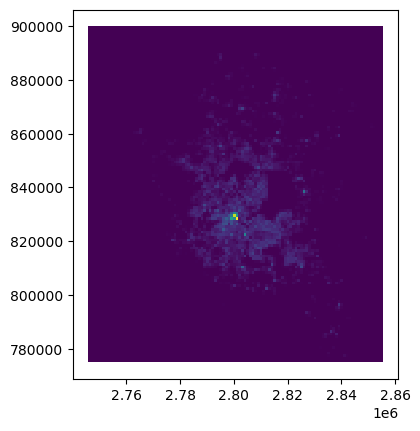

In [ ]:
agregado.datos.plot('puntos')

También es posible agregar los puntos de acuerdo a una clasificación previa. Por ejemplo, supongamos que tenemos datos del DENUE clasificados en tipos de usos de suelo como en el módulo `denue`.

In [ ]:
pth = descarga_denue(tipo='ejemplo')
denue = Denue.desde_archivo(pth)
categorias = {
    'Manufacturas': ['^31.*5$', '^32.*5$', '^33.*5$'],
    'Oficinas': ['^51', '^521', '^523', '^524', '^5312', '^5313', '^541', '^55'],
    'Comercio': ['^46[123456]']
}
usos = denue.agrega_en_usos(categorias)
usos.datos.loc[~usos.datos.Categoria.isnull()][['nom_estab', 'codigo_act', 'Categoria']].head()

El archivo ya está descargado


,nom_estab,codigo_act,Categoria
1,TIENDA NATURISTA EL ARTE DE LA NATURALEZA,464113,Comercio
3,SIN NOMBRE,461130,Comercio
4,ADMINISTRACION MERCADO CONCENTRACION VOCEADORES,531311,Oficinas
6,ABARROTES LA TIA,461110,Comercio
7,BIZUTERIA SIN NOMBRE,463215,Comercio


Entonces podemos usar la columna `Categoria` para agregar los puntos en nuestra malla. La sintaxis es casi igual, sólo que en este caso pasamos el nombre de la columna con la que clasificamos las observaciones: 

In [ ]:
agregado = malla.agrega_puntos(usos.datos, clasificacion='Categoria')
agregado.datos

,grid_id,Comercio,Manufacturas,Oficinas,geometry
0,0,0.0,0.0,0.0,"POLYGON ((2745631.810 774927.105, 2746631.810 ..."
1,1,0.0,0.0,0.0,"POLYGON ((2745631.810 775927.105, 2746631.810 ..."
2,2,0.0,0.0,0.0,"POLYGON ((2745631.810 776927.105, 2746631.810 ..."
3,3,0.0,0.0,0.0,"POLYGON ((2745631.810 777927.105, 2746631.810 ..."
4,4,0.0,0.0,0.0,"POLYGON ((2745631.810 778927.105, 2746631.810 ..."
...,...,...,...,...,...
13745,13745,0.0,0.0,0.0,"POLYGON ((2854631.810 894927.105, 2855631.810 ..."
13746,13746,0.0,0.0,0.0,"POLYGON ((2854631.810 895927.105, 2855631.810 ..."
13747,13747,0.0,0.0,0.0,"POLYGON ((2854631.810 896927.105, 2855631.810 ..."
13748,13748,0.0,0.0,0.0,"POLYGON ((2854631.810 897927.105, 2855631.810 ..."


También podemos usar una columna con pesos para agregar los puntos. Por ejemplo, en el módulo `Denue` se pueden agregar pesos a las actividades económicas de acuerdo al número de empleados, podemos usar estos pesos para agregar esos datos en una malla.

In [ ]:
pesos = {
        '0 a 5 personas': 2,
        '6 a 10 personas': 8,
        '11 a 30 personas': 20,
        '31 a 50 personas': 40,
        '51 a 100 personas': 75,
        '101 a 250 personas': 175,
        '251 y más personas': 300
        }
usos_pesos = usos.pesa_unidades(pesos)
agregado_pesos = malla.agrega_puntos(usos_pesos.datos, clasificacion='Categoria', pesos='pesos')
agregado_pesos.datos

,grid_id,Comercio,Manufacturas,Oficinas,geometry
0,0,0.0,0.0,0.0,"POLYGON ((2745631.810 774927.105, 2746631.810 ..."
1,1,0.0,0.0,0.0,"POLYGON ((2745631.810 775927.105, 2746631.810 ..."
2,2,0.0,0.0,0.0,"POLYGON ((2745631.810 776927.105, 2746631.810 ..."
3,3,0.0,0.0,0.0,"POLYGON ((2745631.810 777927.105, 2746631.810 ..."
4,4,0.0,0.0,0.0,"POLYGON ((2745631.810 778927.105, 2746631.810 ..."
...,...,...,...,...,...
13745,13745,0.0,0.0,0.0,"POLYGON ((2854631.810 894927.105, 2855631.810 ..."
13746,13746,0.0,0.0,0.0,"POLYGON ((2854631.810 895927.105, 2855631.810 ..."
13747,13747,0.0,0.0,0.0,"POLYGON ((2854631.810 896927.105, 2855631.810 ..."
13748,13748,0.0,0.0,0.0,"POLYGON ((2854631.810 897927.105, 2855631.810 ..."


Podemos comparar el resultado de usar o no los pesos: 

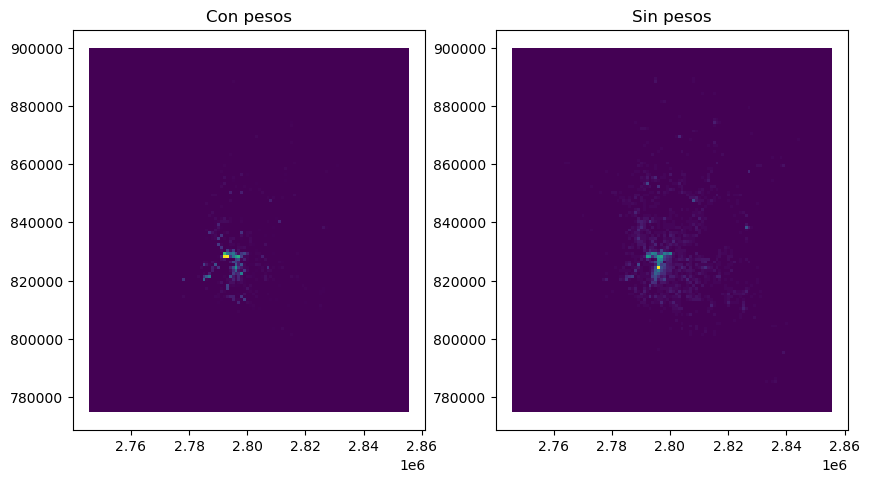

In [ ]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,20))
ax0 = agregado_pesos.datos.plot('Oficinas', ax=ax0)
ax0 = ax0.set_title("Con pesos")
ax1 = agregado.datos.plot('Oficinas', ax=ax1)
ax1 = ax1.set_title("Sin pesos")

#### Agrega líneas{#sec-malla-lineas}

Ahora vamos a añadir la funcionalidad de agregar líneas en la malla. Lo que vamos a hacer es calcular la longitud de las líneas adentro de cada cuadrado de la retícula y utiliza ese valor en la malla. Sirve, por ejemplo, para calcular la longitud total de un tipo de vialidad en cada elemento de la malla.

In [ ]:
#| export

@patch
def agrega_lineas(self:Malla,
                  lineas:gpd.GeoDataFrame, # La capa de líneas a agregar
                  campo: str='longitud', # Nombre del campo en el que se guarda el resultado
                 ) -> Malla:
    """ Regresa una `Malla` con la longitud de las lineas agregadas en cada elemento."""
    if lineas.crs != self.crs:
        lineas = lineas.to_crs(self.crs) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        union = (lineas
                .overlay(self.datos, how='union')
                .dissolve(by='grid_id')
                .length.reset_index()
                .rename({0:campo}, axis=1)   
            )
    union = (self.datos
            .merge(union, on='grid_id', how='left')
            .fillna(0)
        )
    m = Malla(union, self.size)
    return m

Para probar la función, descargamos la red de OSM y filtramos sólo las vialidades primarias 

El archivo ya está descargado


<AxesSubplot:>

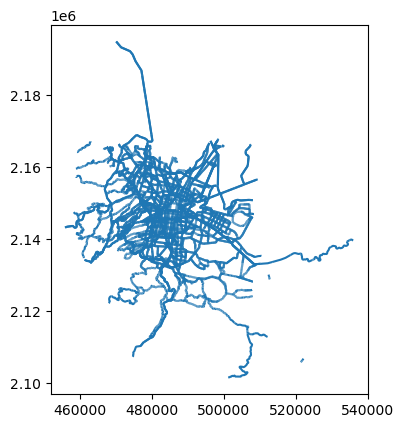

In [ ]:
pth = descarga_redes() # nos aseguramos de tener la red
red = gpd.read_file(pth)
red = red.loc[red.tag_id.isin([104,108,106,101])]
red.plot()

Con esta capa podemos probar la función

In [ ]:
red_malla = malla.agrega_lineas(red, campo='metros_vialidad')
red_malla.datos

,grid_id,geometry,metros_vialidad
0,0,"POLYGON ((2745631.810 774927.105, 2746631.810 ...",0.0
1,1,"POLYGON ((2745631.810 775927.105, 2746631.810 ...",0.0
2,2,"POLYGON ((2745631.810 776927.105, 2746631.810 ...",0.0
3,3,"POLYGON ((2745631.810 777927.105, 2746631.810 ...",0.0
4,4,"POLYGON ((2745631.810 778927.105, 2746631.810 ...",0.0
...,...,...,...
13745,13745,"POLYGON ((2854631.810 894927.105, 2855631.810 ...",0.0
13746,13746,"POLYGON ((2854631.810 895927.105, 2855631.810 ...",0.0
13747,13747,"POLYGON ((2854631.810 896927.105, 2855631.810 ...",0.0
13748,13748,"POLYGON ((2854631.810 897927.105, 2855631.810 ...",0.0


La `Malla` que nos regresa sólo tiene el id de la malla y la longitud de la red dentro de cada elemento de la retícula. Lo podemos ver rápidamente en un mapa

<AxesSubplot:>

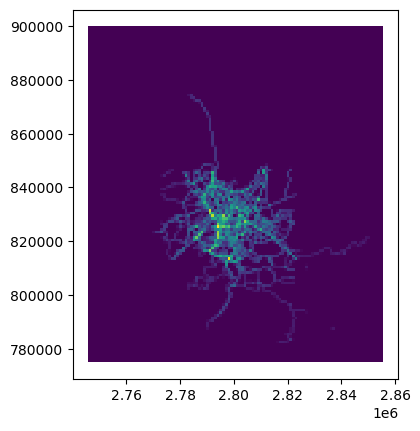

In [ ]:
red_malla.datos.plot('metros_vialidad')

Como cada operación regresa una copia del objeto, podemos _encadenar_ los métodos para ir agregando varias capas en una malla:

In [ ]:
malla_todo = (malla
             .agrega_puntos(puntos, campo="puntos")
             .agrega_lineas(red, campo='metros_vialidad')
             )
malla_todo.datos

,grid_id,puntos,geometry,metros_vialidad
0,0,0.0,"POLYGON ((2745631.810 774927.105, 2746631.810 ...",0.0
1,1,0.0,"POLYGON ((2745631.810 775927.105, 2746631.810 ...",0.0
2,2,0.0,"POLYGON ((2745631.810 776927.105, 2746631.810 ...",0.0
3,3,0.0,"POLYGON ((2745631.810 777927.105, 2746631.810 ...",0.0
4,4,0.0,"POLYGON ((2745631.810 778927.105, 2746631.810 ...",0.0
...,...,...,...,...
13745,13745,0.0,"POLYGON ((2854631.810 894927.105, 2855631.810 ...",0.0
13746,13746,0.0,"POLYGON ((2854631.810 895927.105, 2855631.810 ...",0.0
13747,13747,0.0,"POLYGON ((2854631.810 896927.105, 2855631.810 ...",0.0
13748,13748,0.0,"POLYGON ((2854631.810 897927.105, 2855631.810 ...",0.0


#### Agrega variables del Censo{#sec-censo-mallas} 

Algunas variables importantes para analizar el uso de suelo vienen contenidas en los Censos de Ppoblación y Vivienda del INEGI. Como esta librería busca permitir al usuario la mayor libertad posible en cuanto a las unidades de análisis que escoja, optamos por desarrollar un método que permite partir de las variables censales a escala de manzana urbana y agregarlas en nuestras coberturas.

Agregar las manzanas en coberturas arbitrarioas (regulares o no) implica tener una relación entre los elementos de la cobertura y las manzanas, obviamente esto no se puede hacer de forma exacta porque las fronteras de las manzanas y los elementos de la malla no van a coincidir como se puede ver en la siguiente figura:

![Sobreposición de manzanas y una malla de 1000 metros](malla_poligonos_1.png)




Para resolver este problema, la librería va a asignar automáticamente el id del elemento de la malla a todas las manzanas que estén completamente contenidas en un elemento. El problema va a estar cuando una manzana intersecta a más de un elemento de la malla, para estos casos tenemos dos soluciones alternativas:

* Centro de celda: se asigna el identificador del elemento de la malla en el que caiga el centro de la manzana
* Área máxima: se asigna el identificador del elemento de la malla que contenga una mayor área de la manzana. 

:::{.callout-warning}

Estos métodos funcionan solo cuando el tamaño de la malla es, en general, más grande que las manzanas. Cuando la malla es más pequeña que las manzanas no arroja error pero los resultados no son confiables.

:::

A partir de esta relación, entonces podemos seleccionar qué variables del Censo queremos agregar en nuestra retícula.

:::{.callout-note}

Por lo pronto la librería provee unicamente datos del censo a nivel manzana para la Zona Metropolitana del Valle de México, en el futuro cercano incluiremos las principales ciudades del país.

:::

In [ ]:
#| export
@patch
def agrega_manzanas(self:Malla,
                    manzanas:gpd.GeoDataFrame, # Las manzanas (`descarga_manzanas_ejempolo`).
                    variables:dict, # Diccionario de las variables que querems agregar y el método para agregarlas (p, ej. {'OCUPVIVPAR':'sum'})
                    metodo: str='centro' # centro/area, método para resolver sobreposiciones
    ) -> Malla:
    pd.options.mode.chained_assignment = None
    if manzanas.crs != self.crs:
        manzanas = manzanas.to_crs(self.crs)
    # Primero asignamos el id de la malla a todos los contenidos
    manzanas = (manzanas
                 .sjoin(self.datos, predicate='covered_by', how='left')
                 .drop(columns='index_right'))
    # resolvemos los demás de acuerdo al método selecionado
    sin_asignar = manzanas.loc[manzanas['grid_id'].isna(),:]
    if metodo == 'centro':       
        sin_asignar['geometry'] = sin_asignar['geometry'].centroid
        # sin_asignar.loc[:, 'geometry'] = sin_asignar['geometry'].centroid
        sin_asignar = (sin_asignar
                      .drop(columns='grid_id')
                      .sjoin(self.datos)
                      .drop(columns='index_right'))
    elif metodo == 'area':
        sin_asignar = (sin_asignar
                      .drop(columns='grid_id')
                      .overlay(self.datos))
        sin_asignar['area'] = sin_asignar.geometry.area
        sin_asignar = (sin_asignar
                      .sort_values('area')
                      .drop_duplicates(sin_asignar.columns, keep='last')
                      .drop(columns='geometry'))
    else:
        print("metodo debe ser centro o area")
        raise NotImplementedError


    # Completamos los grid_id en los poligonos    
    manzanas = manzanas.merge(sin_asignar[['CVEGEO', 'grid_id']], on='CVEGEO', how='left')
    manzanas['grid_id'] = (manzanas['grid_id_y']
                            .fillna(manzanas['grid_id_x']))
    manzanas = manzanas.drop(columns=['grid_id_x', 'grid_id_y'])
    manzanas['grid_id'] = manzanas['grid_id'].astype(int)
    # Agrupamos y agregamos
    malla = (manzanas
             .drop(columns=['CVEGEO', 'geometry'])
             .groupby('grid_id')
             .aggregate(variables)
             .reset_index())
    malla = self.datos.merge(malla, on='grid_id', how='left').fillna(0)
    malla = Malla(malla, self.size)
    # return poligonos
    return malla


Vamos a ilustrar el funcionamiento de este método utilizando unos datos del censo a nivel manzana para la CDMX

In [ ]:
pth = descarga_manzanas_ejemplo()
manzanas = gpd.read_file(pth)
manzanas.head()

El archivo ya está descargado


,CVEGEO,VIVPAR_HAB,OCUPVIVPAR,geometry
0,0901000010898031,22.0,93.0,"POLYGON ((2790204.135 820779.247, 2790125.593 ..."
1,0901000012269024,0.0,0.0,"POLYGON ((2791387.916 821465.156, 2791376.215 ..."
2,0901000011472068,33.0,124.0,"POLYGON ((2788494.355 822775.106, 2788478.422 ..."
3,0901000011824024,95.0,340.0,"POLYGON ((2790870.494 819456.298, 2790862.256 ..."
4,0901000012377004,23.0,82.0,"POLYGON ((2792111.138 821977.886, 2792115.437 ..."


Podemos agregar la variable `VIVPAR_HAB` usando la suma y `OCUPVIVPAR` con el promedio, utilizando el método `centro` para resolver las sobreposiciones. 

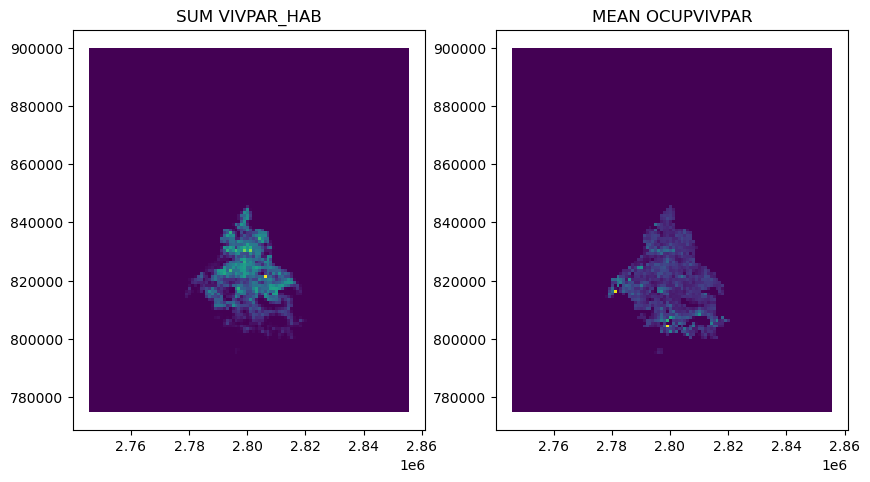

In [ ]:
malla_censo = malla.agrega_manzanas(manzanas, 
                                    {'VIVPAR_HAB': 'sum', 
                                    'OCUPVIVPAR': 'mean'}, 
                                    'centro')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1 = malla_censo.datos.plot('VIVPAR_HAB', ax=ax1)
ax1 = ax1.set_title("SUM VIVPAR_HAB")
ax2 = malla_censo.datos.plot('OCUPVIVPAR', ax=ax2)
ax2 = ax2.set_title("MEAN OCUPVIVPAR")

Ahora podemos probar el método `area` y comparar los resultados.

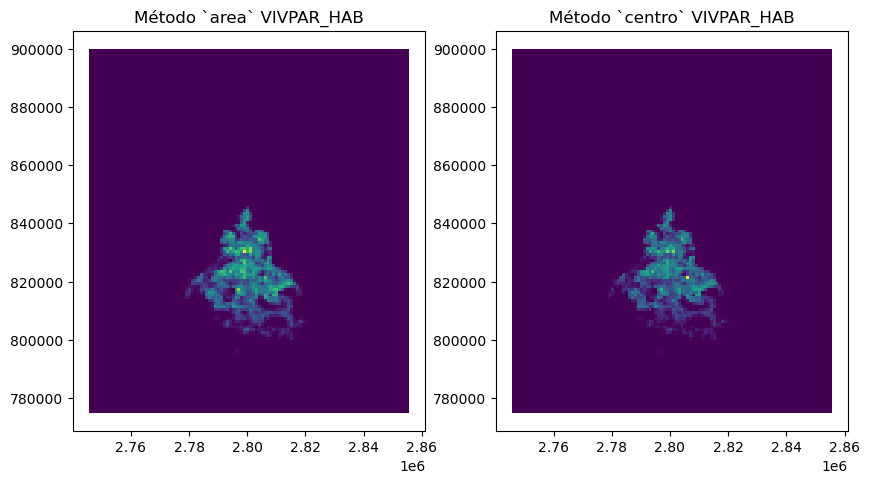

In [ ]:
malla_censo_area = malla.agrega_manzanas(manzanas, 
                                         {'VIVPAR_HAB': 'sum', 
                                         'OCUPVIVPAR': 'mean'}, 
                                         'area')
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1 = malla_censo_area.datos.plot('VIVPAR_HAB', ax=ax1)
ax1 = ax1.set_title("Método `area` VIVPAR_HAB")
ax2 = malla_censo.datos.plot('VIVPAR_HAB', ax=ax2)
ax2 = ax2.set_title("Método `centro` VIVPAR_HAB")                                   

#### Malla a raster

Hasta ahora tenemos una representación vectorial de la malla, lo que sirve muy bien para operaciones espaciales con otras capas, pero una representación más natural y que nos permite operar de formas diferentes es la representación _raster_. En lugar de transformarlas en matrices directamente, vamos a usar `xarray` para representar nuestra malla como un `Dataset` de rasters.

In [ ]:
#| export
@patch
def to_xarray(self:Malla,
              campos: list=None # Lista de campos a convertir, se convierten en bandas del raster
             ):
    """ Regresa un xarray con los `campos` seleccionados como variables."""
    if campos is None:
        campos = [c for c in self.datos.columns if c not in ['geometry', 'grid_id']]     
    cube = make_geocube(vector_data=self.datos, 
                        measurements=campos, 
                        resolution=(self.size, -self.size), 
                       )
    return cube

La función sólo toma como entrada los campos que queremos transformar a raster y regresa un `xarray` con las variables que seleccionamos como `Data variables`, las coordenadas `x` y `y` como `Coordinates` y en la proyección de la malla que le pasemos. 

In [ ]:
cube = malla_todo.to_xarray()
cube

<xarray.Dataset>
Dimensions:          (y: 126, x: 111)
Coordinates:
  * y                (y) float64 7.745e+05 7.755e+05 ... 8.985e+05 8.995e+05
  * x                (x) float64 2.856e+06 2.854e+06 ... 2.746e+06 2.746e+06
    spatial_ref      int64 0
Data variables:
    puntos           (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 nan
    metros_vialidad  (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 nan

Podemos ver el raster correspondiente a cualquiera de las variables

<matplotlib.collections.QuadMesh>

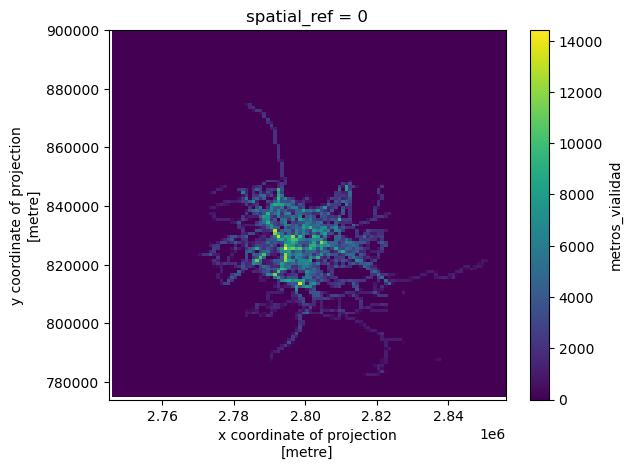

In [ ]:
cube.metros_vialidad.plot()

### Polígonos

Además de calcular este tipo de agregaciones usando mallas regulares, también es importante poder usar unidades espaciales más _naturales_ como por ejemplo Colonias. Para esto, la librería implementa la clase `Poligonos` que permite agregar los mismos tipos de datos que `Mallas` pero en Soportes construidas con polígonos de formas arbitrarias.


In [ ]:
#| export
class Poligonos(Soporte):
    """ Representa una cobertura de polígonos de forma arbitraria 
        para procesar variables de uso de suelo."""
    def __init__ (self,
                 datos:gpd.GeoDataFrame=None, # La malla vectorial
                 id_col:str=None, # Columna que se va a usar para identificar a cada polígono
        ) -> None:
        self.id_col = id_col
        self.datos = datos
        self.crs = datos.crs
    
    @classmethod
    def desde_archivo(cls,
                      path:str, # Path al archivo de datos (cualquiera soportado por GeoPandas), 
                      id_col:str,  # Columna que se va a usar para identificar a cada polígono
                      layer=None
        ):
        gdf = gpd.read_file(path)
        return cls(gdf, id_col)
    def to_crs(self, to_crs: Union[int, str, crs.CRS]):
        ...
        
    def agrega_lineas(self, lineas: gpd.GeoDataFrame, campo: str=None):
        pass
    
    def agrega_puntos(self, puntos: gpd.GeoDataFrame, campo: str=None, clasificacion: str=None):
        pass

    def agrega_manzanas(self, manzanas: gpd.GeoDataFrame, variables):
        ...

In [ ]:
show_doc(Poligonos.desde_archivo)

---

[source](https://github.com/CentroGeo/pyLandUseMX/blob/master/pyLandUseMX/usodesuelo.py#L281){target="_blank" style="float:right; font-size:smaller"}

### Poligonos.desde_archivo

>      Poligonos.desde_archivo (path:str, id_col:str, layer=None)

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| path | str |  | Path al archivo de datos (cualquiera soportado por GeoPandas), |
| id_col | str |  | Columna que se va a usar para identificar a cada polígono |
| layer | NoneType | None |  |

La clase contiene un método para construirla a partir de un archivo (en cualquier formato soportado por Geopandas). Para construir un objeto de esta forma, simplemente le pasamos el path al método y especificamos qué columna deberemos usar como identificador de las unidades espaciales.

In [ ]:
pth = descarga_colonias_cdmx()
poligonos = Poligonos.desde_archivo(pth, 'id')
poligonos.datos.head()

,id,nomut,geometry
0,1,AGUILERA,"POLYGON ((483311.618 2153254.848, 483332.006 2..."
1,2,ALDANA,"POLYGON ((484406.956 2153012.331, 484401.132 2..."
2,3,ANGEL ZIMBRON,"POLYGON ((480013.755 2153003.618, 480063.589 2..."
3,4,ARENAL,"POLYGON ((484061.118 2152622.284, 484061.678 2..."
4,5,CENTRO DE AZCAPOTZALCO,"POLYGON ((480123.402 2154520.928, 480131.648 2..."


### Transformación de coordenadas

In [ ]:
#| export
@patch
def to_crs(self:Poligonos,
           to_crs: Union[int, str, crs.CRS] # El crs al que queremos reproyectar
    ) -> Malla:
    datos = self.datos.to_crs(to_crs)
    m = Poligonos(datos, self.id_col)
    return m

In [ ]:
poligonos_4326 = poligonos.to_crs(4326)
print(poligonos_4326.crs, poligonos.crs)

epsg:4326 epsg:32614


#### Agrega puntos

Igual que con las mallas, tenemos un método para contar puntos adentro de cada unidad.

In [ ]:
#| export
@patch
def agrega_puntos(self:Poligonos,
                  puntos:gpd.GeoDataFrame, # La malla en la que se va a agregar
                  campo: str='cuenta', # Nombre del campo en el que se guarda el resultado
                  clasificacion: str=None # Columna de `puntos` que clasifica a las observaciones. En este caso se agregan
                                          # tantas columnas a la malla como valores distintos haya en la columna
                                          # (en este caso se ignora `campo`)
                ) -> Poligonos:
    """ Regresa un `Poligonos` con los conteos de puntos en cada unidad."""
    if self.crs != puntos.crs:
        puntos = puntos.to_crs(self.crs)
    if 'index_right' in puntos.columns:
        puntos = puntos.drop(columns='index_right')
    if self.id_col in puntos.columns:
        puntos = puntos.drop(columns=self.id_col)
    if clasificacion is None:
        agregado = (puntos
                    .sjoin(self.datos)
                    .groupby(self.id_col)
                    .size()
                    .reset_index()
                    .rename({0:campo}, axis=1)
                    .merge(self.datos, on=self.id_col, how='right').fillna(0))

    else:
        agregado = (puntos
                    .sjoin(self.datos)
                    .groupby([clasificacion, self.id_col])
                    .size()
                    .reset_index()
                    .pivot(index=self.id_col, columns=clasificacion, values=0)                    
                    .merge(self.datos, on=self.id_col, how='right')
                    .fillna(0))
    agregado = (gpd.GeoDataFrame(agregado)
                .set_crs(self.crs))
    p = Poligonos(agregado, self.id_col)
    return p

La forma más sencilla de usar este método es simplemente agregar _todos_ los puntos de una capa en nuestros polígonos

In [ ]:
puntos = gpd.read_file("../../datos/points_sample.zip")
agregado = poligonos.agrega_puntos(puntos, campo="puntos")
agregado.datos

,id,puntos,nomut,geometry
0,1,0.0,AGUILERA,"POLYGON ((483311.618 2153254.848, 483332.006 2..."
1,2,0.0,ALDANA,"POLYGON ((484406.956 2153012.331, 484401.132 2..."
2,3,0.0,ANGEL ZIMBRON,"POLYGON ((480013.755 2153003.618, 480063.589 2..."
3,4,0.0,ARENAL,"POLYGON ((484061.118 2152622.284, 484061.678 2..."
4,5,1.0,CENTRO DE AZCAPOTZALCO,"POLYGON ((480123.402 2154520.928, 480131.648 2..."
...,...,...,...,...
1810,1811,0.0,VILLA PROGRESISTA,"POLYGON ((474406.945 2140353.439, 474418.850 2..."
1811,1812,0.0,VILLA SOLIDARIDAD,"POLYGON ((477048.978 2143204.554, 477054.695 2..."
1812,1813,0.0,VILLA VERDUN,"POLYGON ((473081.154 2138733.281, 473070.790 2..."
1813,1814,0.0,ZENON DELGADO,"POLYGON ((477329.014 2144260.214, 477335.725 2..."


También, como en el caso de las mallas, podemos usar una columna con la clasificación para agregar los usos en los polígonos. Usando la misma clasificación que usamos arriba:

In [ ]:
agregado = poligonos.agrega_puntos(usos.datos, clasificacion='Categoria')
agregado.datos

,id,Comercio,Manufacturas,Oficinas,nomut,geometry
0,1,2.0,0.0,0.0,AGUILERA,"POLYGON ((483311.618 2153254.848, 483332.006 2..."
1,2,6.0,0.0,1.0,ALDANA,"POLYGON ((484406.956 2153012.331, 484401.132 2..."
2,3,4.0,0.0,0.0,ANGEL ZIMBRON,"POLYGON ((480013.755 2153003.618, 480063.589 2..."
3,4,9.0,0.0,0.0,ARENAL,"POLYGON ((484061.118 2152622.284, 484061.678 2..."
4,5,43.0,0.0,4.0,CENTRO DE AZCAPOTZALCO,"POLYGON ((480123.402 2154520.928, 480131.648 2..."
...,...,...,...,...,...,...
1810,1811,5.0,0.0,0.0,VILLA PROGRESISTA,"POLYGON ((474406.945 2140353.439, 474418.850 2..."
1811,1812,0.0,0.0,0.0,VILLA SOLIDARIDAD,"POLYGON ((477048.978 2143204.554, 477054.695 2..."
1812,1813,0.0,0.0,0.0,VILLA VERDUN,"POLYGON ((473081.154 2138733.281, 473070.790 2..."
1813,1814,4.0,0.0,0.0,ZENON DELGADO,"POLYGON ((477329.014 2144260.214, 477335.725 2..."


<AxesSubplot:>

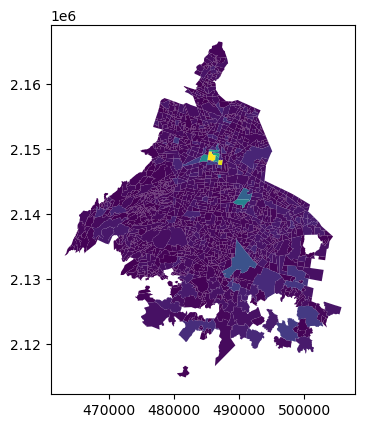

In [ ]:
agregado.datos.plot('Comercio')

#### Agrega líneas

Igual que para el caso de `Malla`, la clase permite agregar líneas en los polígonos, es decir, calcular la cantidad de metros de una capa de líneas que hay adentro de cada elemento de la cobertura de polígonos. En el caso de los polígonos, al ser de forma irregular, tiene sentido calcular la longitud _por unidad de área_, en lugar de solo la longitud, el método permite ambas cosas, pero el default es calcular por unidad de área

In [ ]:
#| export

@patch
def agrega_lineas(self:Poligonos,
                  lineas:gpd.GeoDataFrame, # La capa de líneas a agregar
                  campo: str='longitud', # Nombre del campo en el que se guarda el resultado
                  proporcion:bool=True # ¿Debemos hacer el cálculo por unidad de área?
                 ) -> Malla:
    """ Regresa un `Poligonos` con la longitud de las lineas agregadas en cada elemento."""
    if lineas.crs != self.crs:
        lineas = lineas.to_crs(self.crs) 
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        union = (lineas
                .overlay(self.datos, how='union')
                .dissolve(by=self.id_col)
                .length.reset_index()
                .rename({0:campo}, axis=1)   
            )
    union = (self.datos
            .merge(union, on=self.id_col, how='left')
            .fillna(0)
        )
    if proporcion:
        union['area'] = union.geometry.area
        union[campo] = union[campo].divide(union['area'])
        union = union.drop(columns='area')
    p = Poligonos(union, self.id_col)
    return p

Podemos probar esta función con la misma red que usamos en @sec-malla-lineas

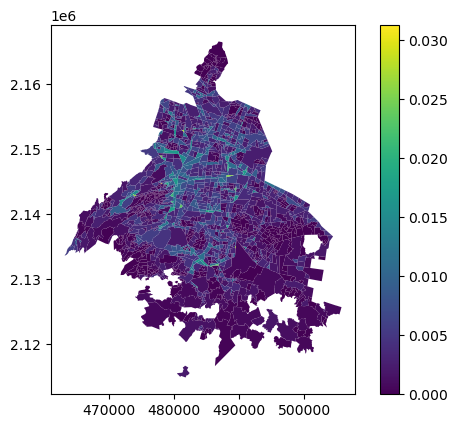

In [ ]:
poligonos_red = poligonos.agrega_lineas(red)
ax = poligonos_red.datos.plot('longitud', legend=True)

#### Agrega variables del censo

Igual que en el caso de las mallas regulares (@sec-censo-mallas), es necesario contar con métodos para agregar variables censales en unidades irregulares. Los problemas en este caso son exáctamente los mismos que los que se enfrentan en ese caso y la solución que ofrece la librería es muy similar, en este caso sólo implementamos el método del centro para resolver las sobreposiciones.

In [ ]:
#| export
@patch
def agrega_manzanas(self:Poligonos, 
                    manzanas:gpd.GeoDataFrame, # Las manzanas (`descarga_manzanas_ejempolo`).
                    variables:dict # Diccionario de las variables que querems agregar y el método para agregarlas (p, ej. {'OCUPVIVPAR':'sum'})
    )-> Poligonos:
    if manzanas.crs != self.crs:
        manzanas = manzanas.to_crs(self.crs)
    relacion = manzanas[["CVEGEO", "geometry"]]
    relacion["geometry"] = manzanas.centroid
    relacion = relacion.sjoin(self.datos).drop(columns=['index_right', 'geometry'])
    manzanas = manzanas.merge(relacion, on="CVEGEO")
    poligonos = (manzanas
                 .groupby(self.id_col)
                 .aggregate(variables)
                 .reset_index())
    poligonos = self.datos.merge(poligonos, on=self.id_col, how='left').fillna(0)
    p = Poligonos(poligonos, self.id_col)
    return p

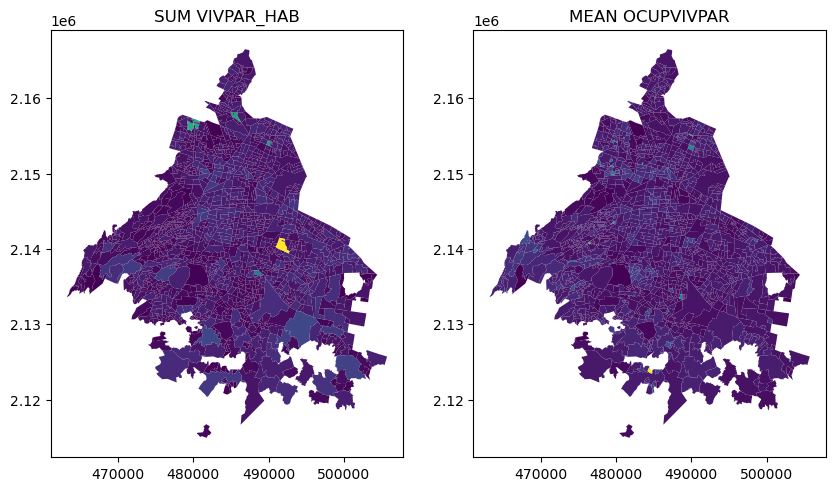

In [ ]:
agregado_censo = poligonos.agrega_manzanas(manzanas, {'VIVPAR_HAB': 'sum', 
                                                     'OCUPVIVPAR': 'mean'})
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,20))
ax1 = agregado_censo.datos.plot('VIVPAR_HAB', ax=ax1)
ax1 = ax1.set_title("SUM VIVPAR_HAB")
ax2 = agregado_censo.datos.plot('OCUPVIVPAR', ax=ax2)
ax2 = ax2.set_title("MEAN OCUPVIVPAR")

## UsoDeSuelo

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()